In [1]:
import sys
utils = "/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/src"
if utils not in sys.path:
    sys.path.append(utils)

from utils.file_utils import add_project_dirs_to_path

# Add project root and src directory to Python path
add_project_dirs_to_path()

# Standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Import from project modules
from modeling.vae_model import *
from utils.data_processing import *
from utils.plotting import *

# Import Keras callback
from keras.callbacks import ModelCheckpoint

# Import plot packages
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
import seaborn

# Suppress warnings
warnings.filterwarnings("ignore")

# Autoreload modules
%load_ext autoreload
%autoreload 2

# Show plots inline
%matplotlib inline

2024-04-03 16:12:07.992550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Introduction

- This notebook will focus primarily on the visual cortex, because there is a stronger signal to noise ratio for purely visual behavior variables.
- Additionally, I have been spooked to look at each brain region independently
- Also go spooked that there are outliers in the kinematics information (Velocity, position, total distance)

In [2]:
VERSION = 2
LATENT_DIM = 10
RANDOM_SEED = 999
BRAIN_REGIONS = ['CA1', 'VISp']
MODEL_TYPES = ['vae', 'pivae']

# Save Plots flags
SAVE_VAL_PLOTS = False
SAVE_LATENT_PLOTS = True

# Show Plots flags
SHOW_VAL_PLOTS = False
SHOW_LATENT_PLOTS = True

# Flag for if this is training iteration
TRAINING =  False

### Extract data

In [3]:
ecephys_session_id = 766640955
brain_region = BRAIN_REGIONS[1]

spike_count_pivot, behavior_data_df = extract_data(ecephys_session_id, brain_region)

## Workflows

### Pi-VAE - X_v, F

#### Transform Data

In [4]:
selected_behavior_vars = ['frame']

x_all, u_all = transform_data(spike_count_pivot, behavior_data_df, selected_behavior_vars)

#### Load Data

In [5]:
x_train, u_train, x_valid, u_valid, x_test, u_test = load_data(x_all=x_all, u_all=u_all)

In [6]:
model_chk_path, workflow_name = get_model_paths(brain_region=brain_region,
                                    selected_behavior_vars=selected_behavior_vars, 
                                    latent_dim=LATENT_DIM, 
                                    random_seed=RANDOM_SEED, 
                                    model_type=MODEL_TYPES[1]);

In [7]:
# Initialize model
vae = initialize_model(dim_x=x_all[0].shape[-1], 
                       dim_z=LATENT_DIM,
                       dim_u=u_all[0].shape[-1], 
                       gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4, random_seed=RANDOM_SEED)

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 49)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 encoder (Functional)        [(None, 10),                 15420     ['input_1[0][0]',             
                              (None, 10),                            'input_3[0][0]']             
                              (None, 10),                                                         
                              (None, 10),                                                       

In [8]:
# Train model
if TRAINING:
    s_n = train_model(vae, x_train, u_train, x_valid, u_valid, model_chk_path)

    plot_validation_loss(s_n, workflow_name, VERSION, save_plot=SAVE_VAL_PLOTS, show_plot=SHOW_VAL_PLOTS)

In [9]:
outputs = inference(vae, x_all, u_all, model_chk_path) # post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var

##### TODO: clean/Package this variance compute and sort code

In [10]:
# Calculate variances of all columns of outputs[0]
variances = outputs[0].var(axis=0)

# Sort the columns by variance in descending order and get the indices
sorted_indices = np.argsort(variances)[::-1]

# Create a new object containing the columns of outputs[0] sorted by variance
sorted_outputs = outputs[0][:, sorted_indices]

print(sorted_outputs.var(axis=0))

[1.8014930e+00 5.2952099e-01 3.9565796e-01 1.0131825e-01 4.0950395e-02
 3.7430849e-02 2.6939096e-02 6.9176755e-03 1.9900755e-03 1.9533213e-04]


In [ ]:
plot_multi_latent_trajectory_pupil_v4(behavior_data_df, outputs, sorted_indices, workflow_name, variances=variances, num_stims=5, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

#### Plotting

In [12]:
sorted_indices

array([3, 5, 7, 6, 8, 2, 4, 9, 0, 1])

Latent 1 idx: 0
Latent 2 idx: 1


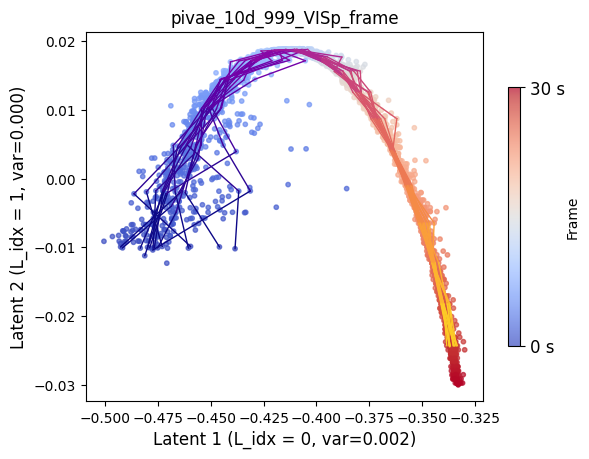

Latent 1 idx: 0
Latent 2 idx: 1


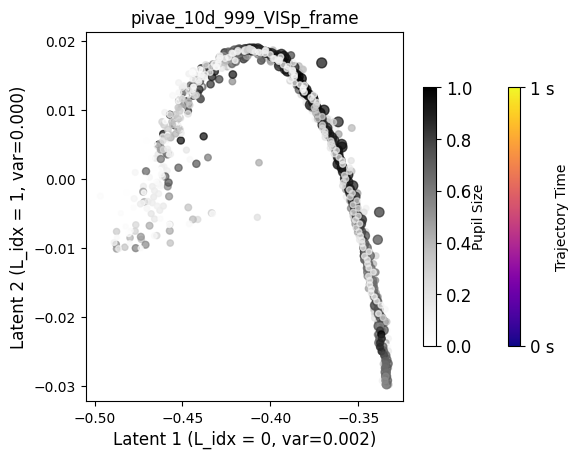

In [15]:
plot_dir = get_plot_dir(workflow_name, version_number=VERSION, plot_type='latent')

plot_multi_latent_trajectory(outputs, sorted_indices, workflow_name, variances=variances, num_stims=15, save_plot=SAVE_LATENT_PLOTS, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

plot_multi_latent_trajectory_pupil_v4(behavior_data_df, outputs, sorted_indices[-2:], workflow_name, variances=variances, num_stims=5, show_traj=False, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

# plot_multi_latent_trajectory(outputs, sorted_indices[::-1], workflow_name+"_inv", variances=variances, num_stims=15, save_plot=SAVE_LATENT_PLOTS, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

# plot_multi_latent_trajectory(outputs, [6,2], workflow_name+"_structure", variances=variances, num_stims=15, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

Latent 1 idx: 0
Latent 2 idx: 6


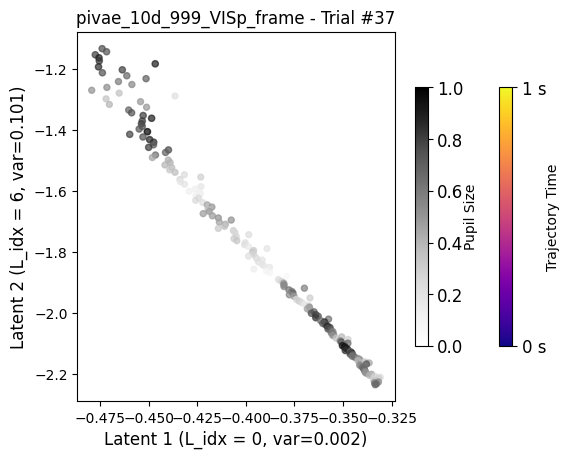

Latent 1 idx: 0
Latent 2 idx: 8


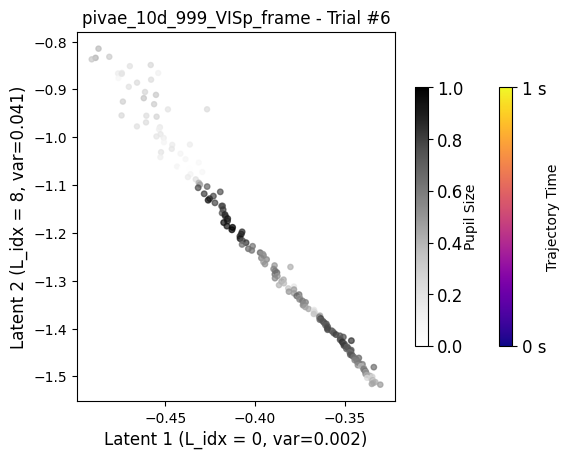

Latent 1 idx: 0
Latent 2 idx: 2


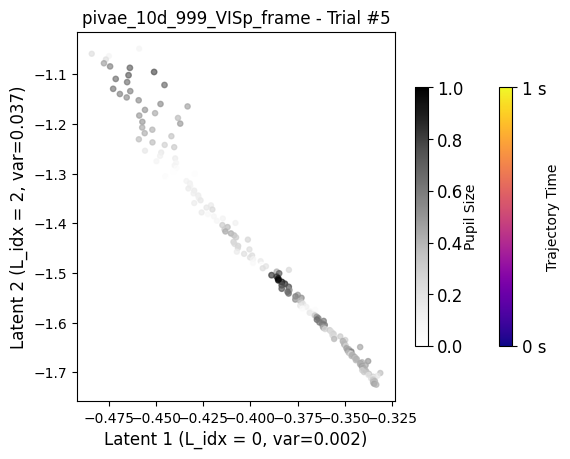

In [28]:
for i in sorted_indices[3:-4]:
    plot_multi_latent_trajectory_pupil_v4(behavior_data_df, outputs, [0, i], workflow_name, variances=variances, num_stims=1, show_traj=False, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

In [1]:
plot_multi_latent_trajectory_pupil_v4(behavior_data_df, outputs, [0, 8], workflow_name, variances=variances, num_stims=20, show_traj=False, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

plot_multi_latent_trajectory_pupil_v4(behavior_data_df, outputs, [0, 8], workflow_name, variances=variances, num_stims=20, show_traj=True, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

NameError: name 'plot_multi_latent_trajectory_pupil_v4' is not defined

Latent 1 idx: 6
Latent 2 idx: 8


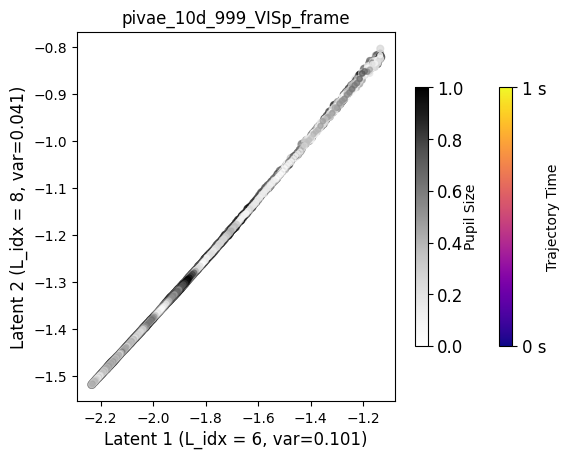

In [34]:
plot_multi_latent_trajectory_pupil_v4(behavior_data_df, outputs, [6, 8], workflow_name, variances=variances, num_stims=20, show_traj=False, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)


In [37]:
from utils.plotting import *

Latent 1 idx: 0
Latent 2 idx: 1


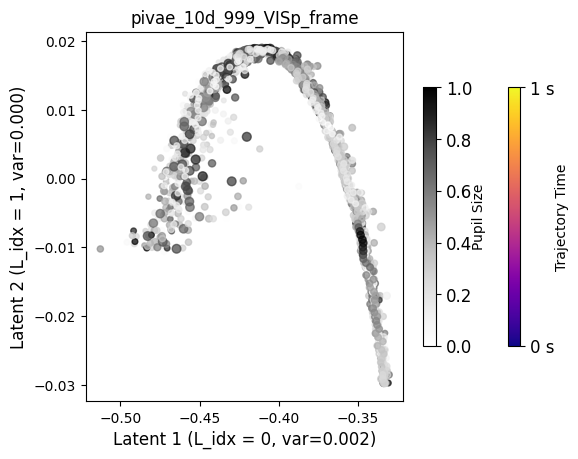

In [79]:
plot_multi_latent_trajectory_pupil_v4(behavior_data_df, outputs, [0,1], workflow_name, variances=variances, num_stims=10, show_traj=False, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

#### Latent 8

Latent 1 idx: 0
Latent 2 idx: 8


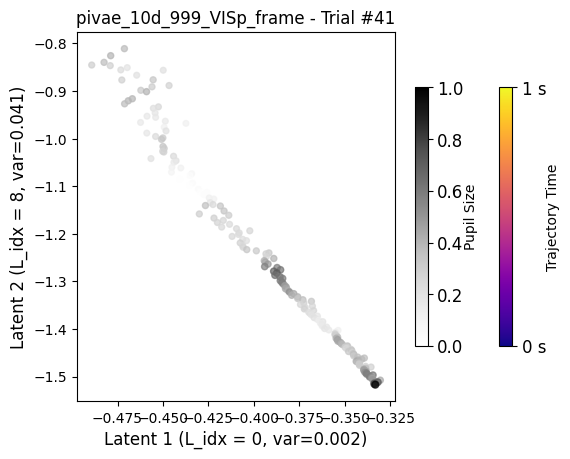

Latent 1 idx: 0
Latent 2 idx: 8


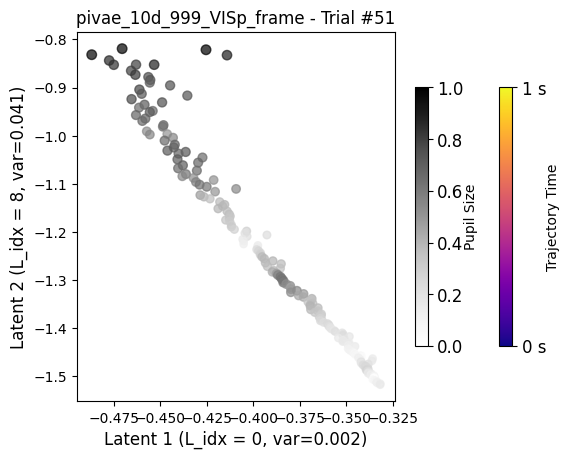

Latent 1 idx: 0
Latent 2 idx: 8


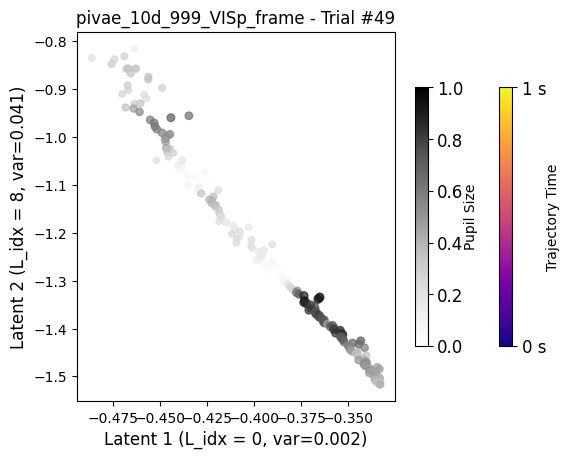

In [58]:
for i in range(3):
    plot_multi_latent_trajectory_pupil_v4(behavior_data_df, outputs, [0,8], workflow_name, variances=variances, num_stims=1, show_traj=False, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

#### Latent 6

Latent 1 idx: 0
Latent 2 idx: 6


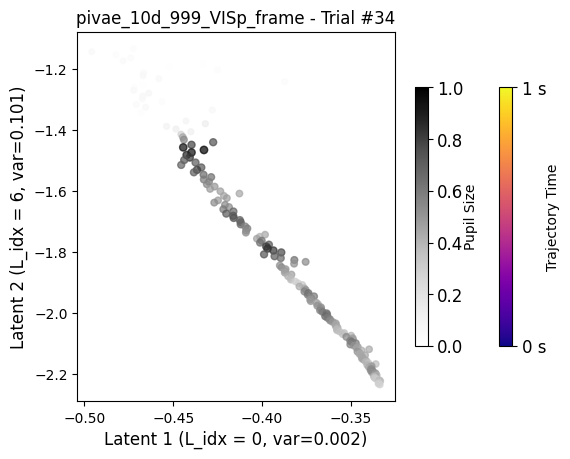

Latent 1 idx: 0
Latent 2 idx: 6


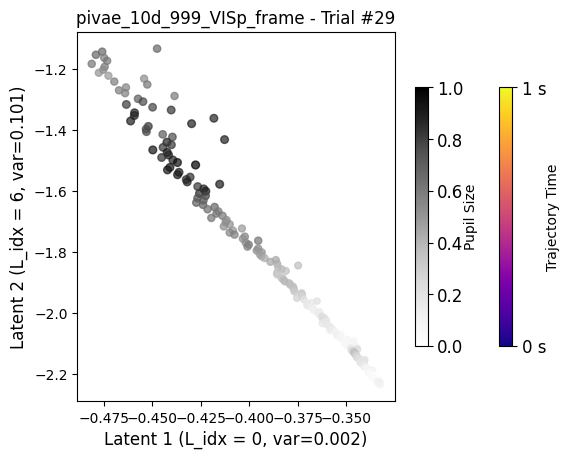

Latent 1 idx: 0
Latent 2 idx: 6


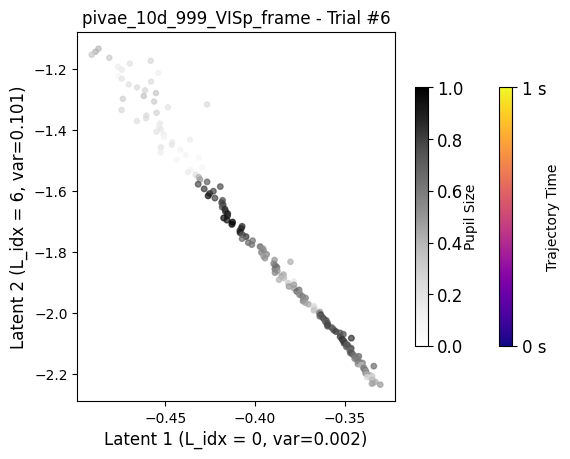

In [59]:
for i in range(3):
    plot_multi_latent_trajectory_pupil_v4(behavior_data_df, outputs, [0,6], workflow_name, variances=variances, num_stims=1, show_traj=False, save_plot=False, save_dir=plot_dir, show_plot=SHOW_LATENT_PLOTS)

In [108]:
'''
STATISTICALY PROVING VISp_frame doesnt show a correlation with pupil_size encoding

Iterate all latents
encoding_effectiveness_plot (plot pupil size vs latent value(y axis) )
determine R2
determine p
determine if you can accept or reject the hypothesis
note down which ones work
'''
from utils.model_utils import *


Analyzing Latent 0...


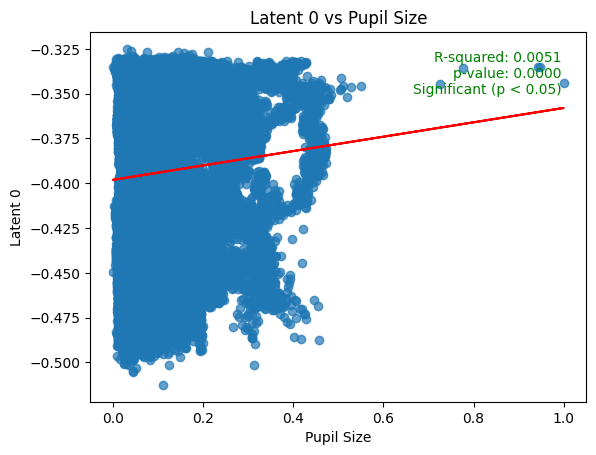

R-squared value for Latent 0: 0.005068488629877775
p-value for Latent 0: 1.2588516416465354e-61
We can reject the null hypothesis for Latent 0.
True
Analyzing Latent 1...


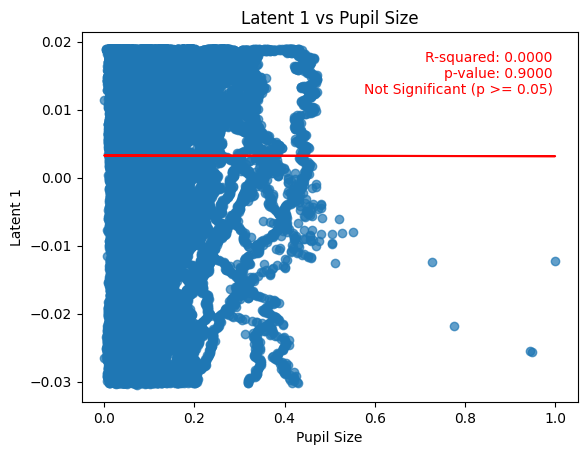

R-squared value for Latent 1: 2.924750546848676e-07
p-value for Latent 1: 0.8999932282757643
We cannot reject the null hypothesis for Latent 1.
False
Analyzing Latent 2...


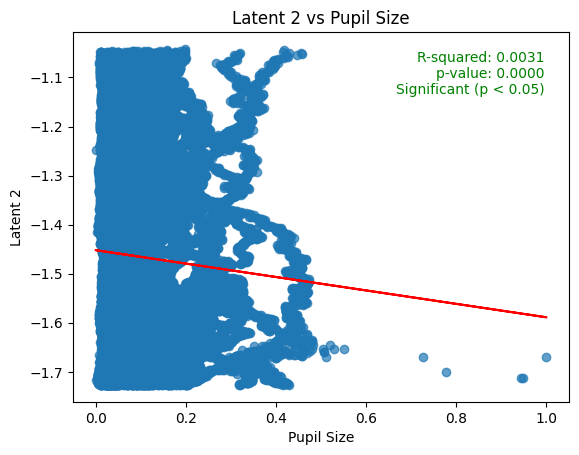

R-squared value for Latent 2: 0.0031351883411953915
p-value for Latent 2: 9.239433129099733e-39
We can reject the null hypothesis for Latent 2.
True
Analyzing Latent 3...


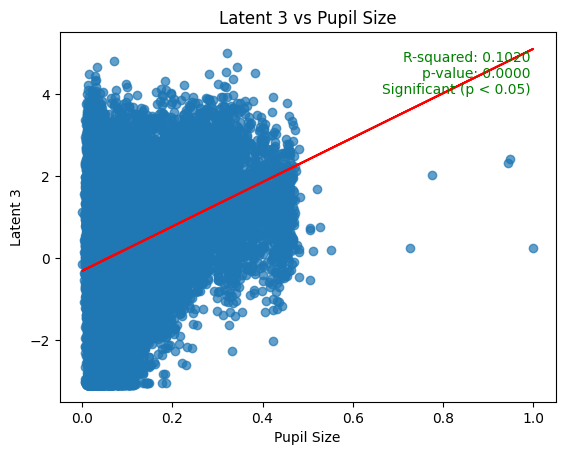

R-squared value for Latent 3: 0.1020210641069863
p-value for Latent 3: 0.0
We can reject the null hypothesis for Latent 3.
True
Analyzing Latent 4...


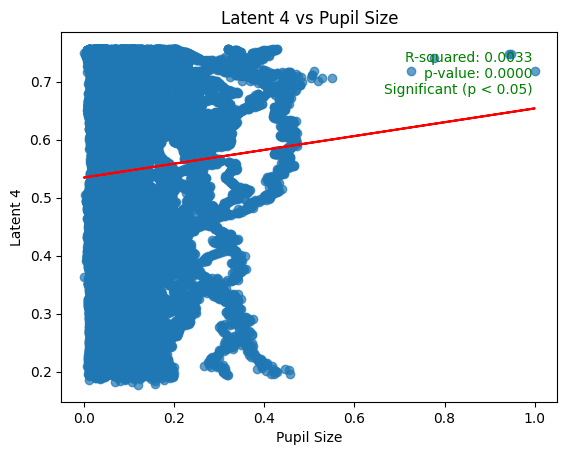

R-squared value for Latent 4: 0.0032989377273437187
p-value for Latent 4: 1.0677532302281737e-40
We can reject the null hypothesis for Latent 4.
True
Analyzing Latent 5...


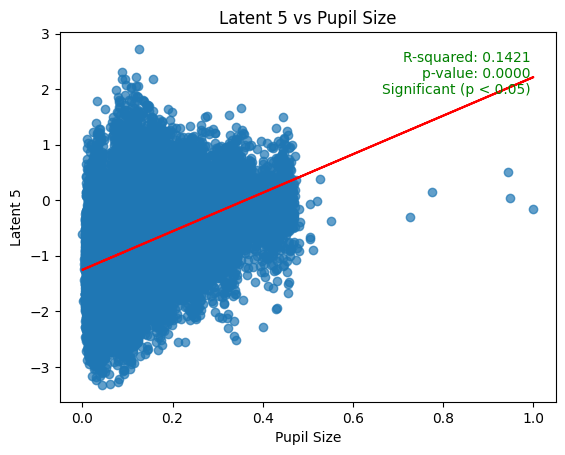

R-squared value for Latent 5: 0.14209463353607785
p-value for Latent 5: 0.0
We can reject the null hypothesis for Latent 5.
True
Analyzing Latent 6...


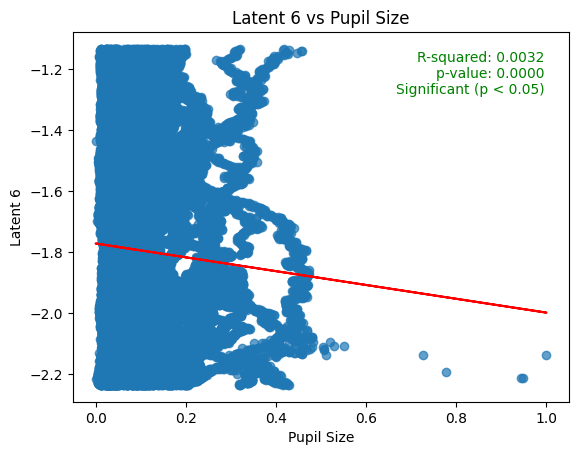

R-squared value for Latent 6: 0.0031757712782599866
p-value for Latent 6: 3.058596473999742e-39
We can reject the null hypothesis for Latent 6.
True
Analyzing Latent 7...


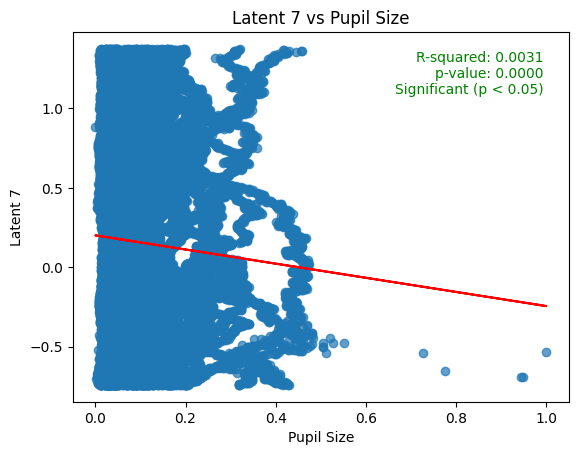

R-squared value for Latent 7: 0.0031360730075968768
p-value for Latent 7: 9.019427373280409e-39
We can reject the null hypothesis for Latent 7.
True
Analyzing Latent 8...


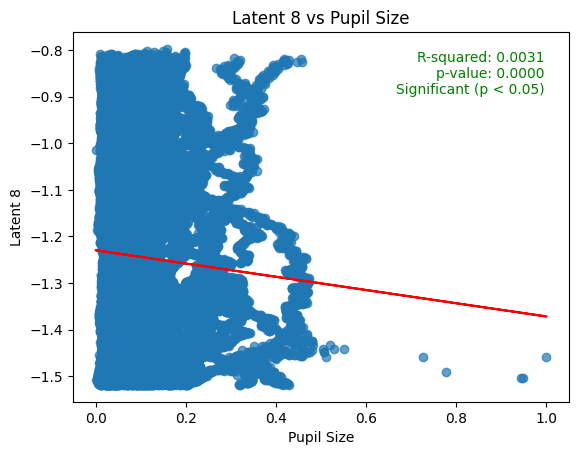

R-squared value for Latent 8: 0.00308913965798409
p-value for Latent 8: 3.2393022143643983e-38
We can reject the null hypothesis for Latent 8.
True
Analyzing Latent 9...


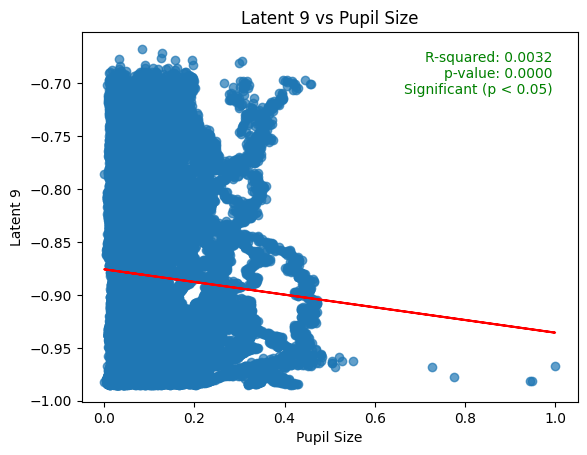

R-squared value for Latent 9: 0.00324146931908211
p-value for Latent 9: 5.1086079238815204e-40
We can reject the null hypothesis for Latent 9.
True
['Latent 0', 'Latent 2', 'Latent 3', 'Latent 4', 'Latent 5', 'Latent 6', 'Latent 7', 'Latent 8', 'Latent 9']


In [104]:
# Example usage:
num_trials = 60
shift = 0
latents_to_plot = [i for i in range(10)]

latents = {f"Latent {latent_idx}": outputs[0][:, latent_idx][900*shift:900*num_trials+900*shift] for latent_idx in latents_to_plot}
pupil_sizes = behavior_data_df['pupil_size'][:900*num_trials]
significant_latents = statistical_proving_visp_frame_correlation_v2(pupil_sizes, latents)

print(significant_latents)

In [71]:
significant_latents

Analyzing Latent 3...


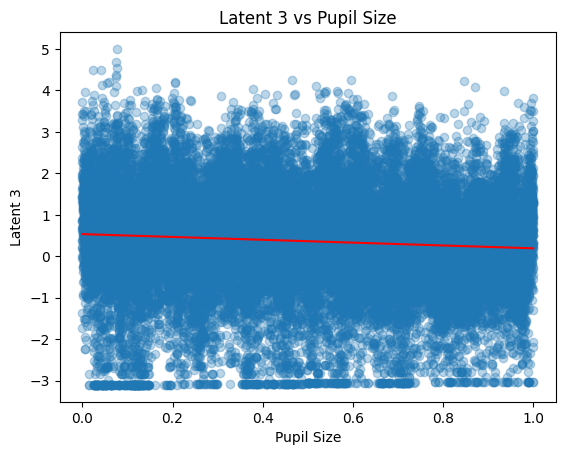

R-squared value for Latent 3: 0.005971665120323264
p-value for Latent 3: 4.802891947478623e-37
We can reject the null hypothesis for Latent 3.
True
Analyzing Latent 5...


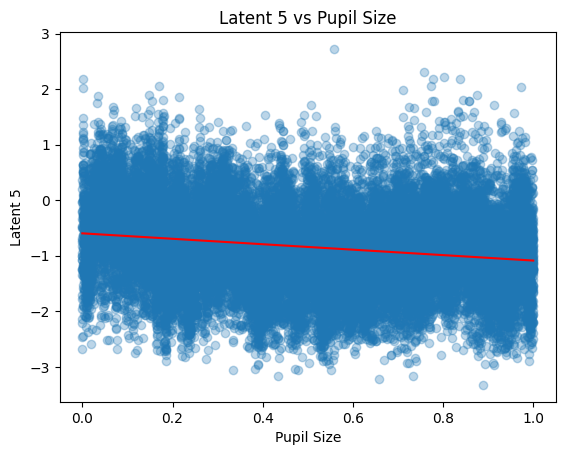

R-squared value for Latent 5: 0.036877920559096604
p-value for Latent 5: 1.3087740588001797e-222
We can reject the null hypothesis for Latent 5.
True
Analyzing Latent 7...


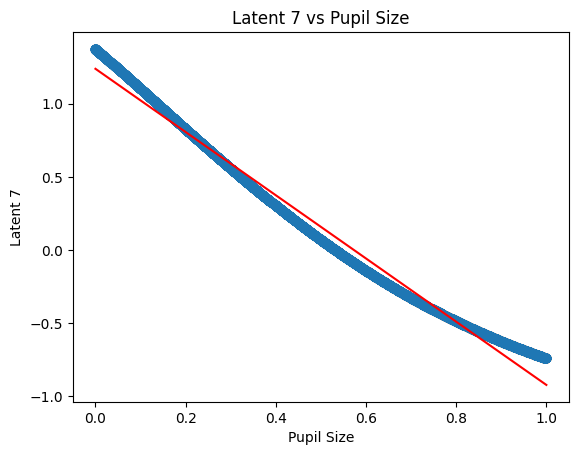

R-squared value for Latent 7: 0.985232207594777
p-value for Latent 7: 0.0
We can reject the null hypothesis for Latent 7.
True
Analyzing Latent 6...


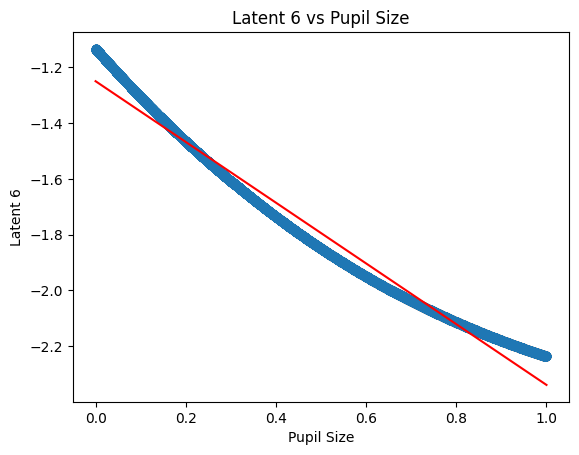

R-squared value for Latent 6: 0.9760726913712825
p-value for Latent 6: 0.0
We can reject the null hypothesis for Latent 6.
True
Analyzing Latent 8...


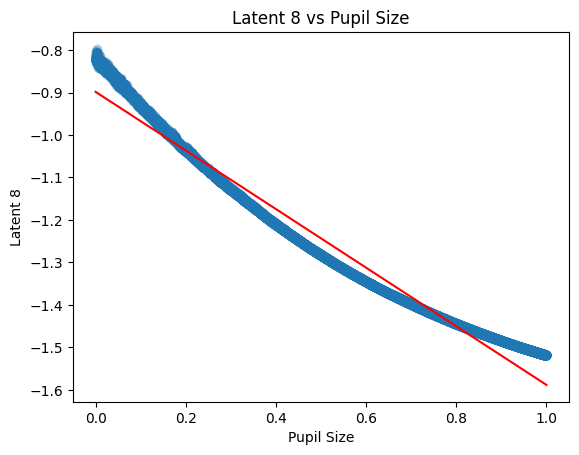

R-squared value for Latent 8: 0.9706723621951661
p-value for Latent 8: 0.0
We can reject the null hypothesis for Latent 8.
True
Analyzing Latent 2...


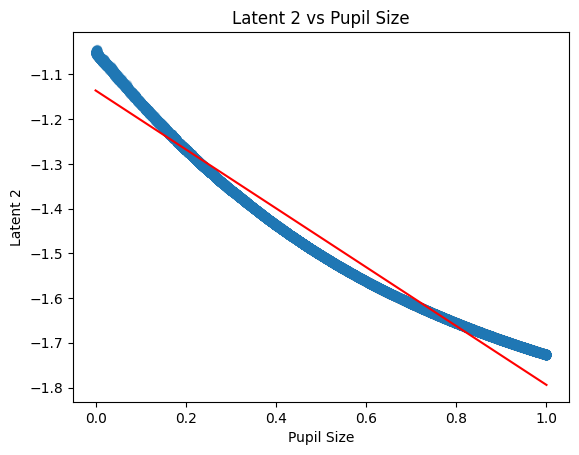

R-squared value for Latent 2: 0.9670204722457278
p-value for Latent 2: 0.0
We can reject the null hypothesis for Latent 2.
True
Analyzing Latent 4...


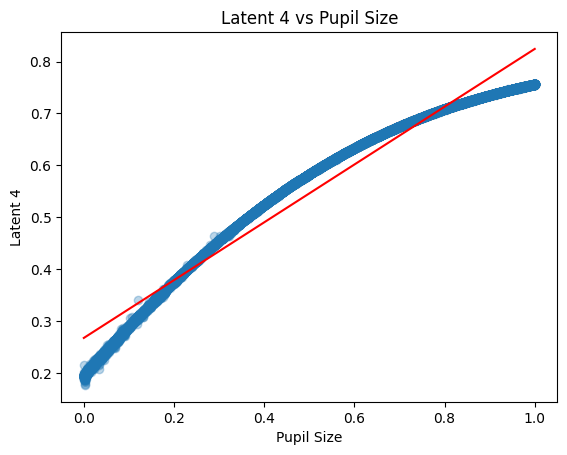

R-squared value for Latent 4: 0.9603418609928819
p-value for Latent 4: 0.0
We can reject the null hypothesis for Latent 4.
True
Analyzing Latent 9...


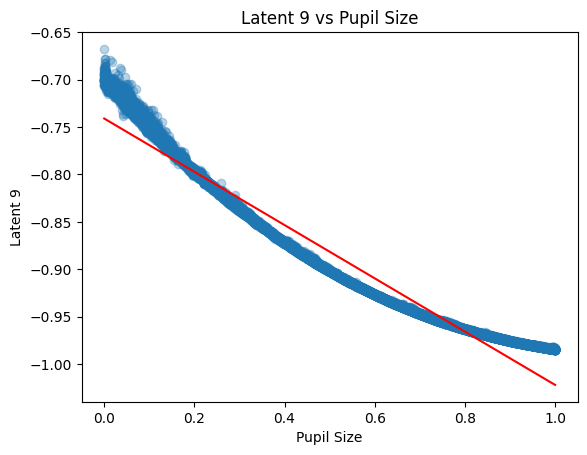

R-squared value for Latent 9: 0.952181542903054
p-value for Latent 9: 0.0
We can reject the null hypothesis for Latent 9.
True
Analyzing Latent 0...


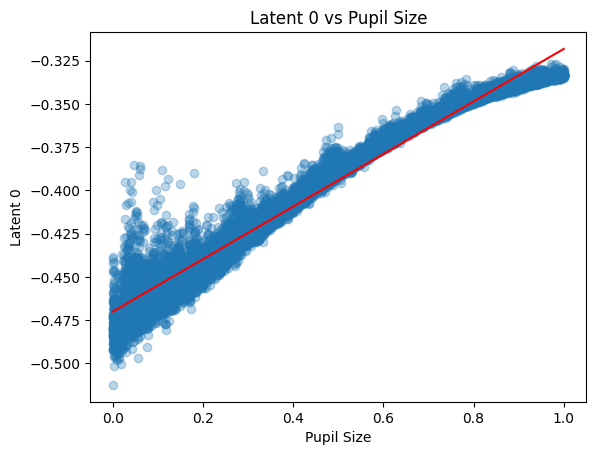

R-squared value for Latent 0: 0.971310457449617
p-value for Latent 0: 0.0
We can reject the null hypothesis for Latent 0.
True
Analyzing Latent 1...


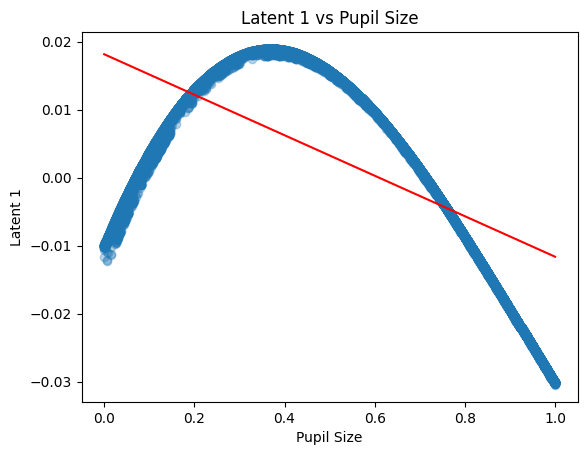

R-squared value for Latent 1: 0.3785838309716403
p-value for Latent 1: 0.0
We can reject the null hypothesis for Latent 1.
True


In [97]:
num_trials = 30
shift = 20

latents = {f"Latent {latent_idx}": outputs[0][:, latent_idx][900*shift:900*num_trials+900*shift] for latent_idx in sorted_indices}
pupil_sizes = behavior_data_df['frame'][:900*num_trials]
significant_latents = statistical_proving_visp_frame_correlation(pupil_sizes, latents)

In [106]:
workflow_name

'pivae_10d_999_VISp_frame'

In [110]:
plot_dir

'/Users/rp/Desktop/Research/CN^3/Thesis Material/2-Region-Latent-Alignment/plots/pivae_10d_999_VISp_frame/v2/metric'

In [119]:
plot_dir = get_plot_dir(workflow_name, version_number=VERSION, plot_type='metric')

num_trials = 60
shift = 0

latents = {f"Latent {latent_idx}": outputs[0][:, latent_idx][900*shift:900*num_trials+900*shift] for latent_idx in range(10)}
b_vars_to_plot = ['pupil_size']

In [120]:
statistical_proving_latent_behavior_correlation(behavior_data_df, b_vars_to_plot, latents, workflow_name, r_squared_threshold=0.1, 
                                                  show_plots=True, save_plots=False, save_path=plot_dir)

Analyzing Latent 0 with pupil_size...
Analyzing Latent 1 with pupil_size...
Analyzing Latent 2 with pupil_size...
Analyzing Latent 3 with pupil_size...
Analyzing Latent 4 with pupil_size...
Analyzing Latent 5 with pupil_size...
Analyzing Latent 6 with pupil_size...
Analyzing Latent 7 with pupil_size...
Analyzing Latent 8 with pupil_size...
Analyzing Latent 9 with pupil_size...
Analyzing Latent 0 with frame...
Analyzing Latent 1 with frame...
Analyzing Latent 2 with frame...
Analyzing Latent 3 with frame...
Analyzing Latent 4 with frame...
Analyzing Latent 5 with frame...
Analyzing Latent 6 with frame...
Analyzing Latent 7 with frame...
Analyzing Latent 8 with frame...
Analyzing Latent 9 with frame...


{'pupil_size': ['Latent 3', 'Latent 5'],
 'frame': ['Latent 0',
  'Latent 1',
  'Latent 2',
  'Latent 4',
  'Latent 6',
  'Latent 7',
  'Latent 8',
  'Latent 9']}

<Figure size 640x480 with 0 Axes>